<a href="https://colab.research.google.com/github/Lonelobo-byte/VideoFake/blob/main/Flux.1-redux-jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown <center><h1>Install</h1></center>

%cd /content
!git clone -b totoro6 https://github.com/LucipherDev/ComfyUI /content/TotoroUI
!git clone -b totoro https://github.com/LucipherDev/ComfyUI_AdvancedRefluxControl /content/TotoroUI/custom_nodes/TotoroUI_AdvancedRefluxControl
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

import nodes

if not nodes.load_custom_node("custom_nodes/TotoroUI_AdvancedRefluxControl"):
  raise Exception("Failed to load Advanced Redux custom node")

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 17747, done.
remote: Total 17747 (delta 0), reused 0 (delta 0), pack-reused 17747 (from 1)
Receiving objects: 100% (17747/17747), 59.49 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (11963/11963), done.
Cloning into '/content/TotoroUI/custom_nodes/TotoroUI_AdvancedRefluxControl'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 86 (delta 50), reused 58 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (86/86), 30.24 KiB | 1.26 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:

In [2]:
#@markdown <center><h1>Load Models</h1></center>

import torch
from nodes import NODE_CLASS_MAPPINGS

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
CLIPVisionLoader = NODE_CLASS_MAPPINGS["CLIPVisionLoader"]()
StyleModelLoader = NODE_CLASS_MAPPINGS["StyleModelLoader"]()

flux_version = "dev" # @param ["dev","schnell"]

print(f"Downloading Flux.1-{flux_version}...")

if flux_version == "schnell":
  !aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors -d /content/TotoroUI/models/unet -o flux1-schnell.safetensors
elif flux_version == "dev":
  !aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev.safetensors

print("Downloading VAE...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft

print("Downloading Clips...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

print("Downloading Clip Vision...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/sigclip_vision_384/resolve/main/sigclip_vision_patch14_384.safetensors -d /content/TotoroUI/models/clip_vision -o sigclip_vision_patch14_384.safetensors

print("Downloading Flux.1-Redux-dev...")
!aria2c --quiet --console-log-level=error --auto-file-renaming=false --allow-overwrite=false -c -x 16 -s 16 -k 1M https://huggingface.co/second-state/FLUX.1-Redux-dev-GGUF/resolve/main/flux1-redux-dev.safetensors -d /content/TotoroUI/models/style_models -o flux1-redux-dev.safetensors

with torch.inference_mode():
    print("Loading VAE...")
    vae = VAELoader.load_vae("ae.sft")[0]
    print(f"Loading Flux.1-{flux_version}...")
    unet = UNETLoader.load_unet(f"flux1-{flux_version}.safetensors", "fp8_e4m3fn")[0]
    print("Loading Clips...")
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    print("Loading Clip Vision...")
    clip_vision = CLIPVisionLoader.load_clip("sigclip_vision_patch14_384.safetensors")[0]
    print("Loading Style Model...")
    style_model = StyleModelLoader.load_style_model("flux1-redux-dev.safetensors")[0]

print("All Models Loaded!")

import re
import os
import gc
import random
import numpy as np
from google.colab import files, output
from IPython.display import HTML, display
import base64
from PIL import Image, ImageOps
import io
import random

import nodes
from totoro_extras import nodes_custom_sampler
from totoro_extras import nodes_post_processing
from totoro_extras import nodes_flux
from totoro_extras import nodes_mask
from totoro import model_management

CLIPTextEncodeFlux = nodes_flux.NODE_CLASS_MAPPINGS["CLIPTextEncodeFlux"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
LoadImage = NODE_CLASS_MAPPINGS["LoadImage"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
VAEEncode = NODE_CLASS_MAPPINGS["VAEEncode"]()
ImageToMask = nodes_mask.NODE_CLASS_MAPPINGS["ImageToMask"]()
MaskToImage = nodes_mask.NODE_CLASS_MAPPINGS["MaskToImage"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()
ReduxAdvanced = NODE_CLASS_MAPPINGS["ReduxAdvanced"]()

Loading VAE...
Loading Flux.1-dev...
Loading Clips...


Loading Clip Vision...
Loading Style Model...
All Models Loaded!


In [6]:
 # @markdown <ul><li><h2>Load Flux Redux</h2></li></ul>

enable_image_1 = True # @param {"type":"boolean"}
input_image_1 = "/content/test.png" # @param {"type":"string"}
enable_image_2 = False # @param {"type":"boolean"}
input_image_2 = "/content/test.png" # @param {"type":"string"}
enable_image_3 = False # @param {"type":"boolean"}
input_image_3 = "/content/test.png" # @param {"type":"string"}
downsampling_function = "area" # @param ["nearest","bilinear","bicubic","area","nearest-exact"]
resize_mode = "autocrop with mask" # @param ["center crop (square)","keep aspect ratio","autocrop with mask"]

input_images = {
    1: [enable_image_1, input_image_1, None, 3, 1.0],
    2: [enable_image_2, input_image_2, None, 3, 1.0],
    3: [enable_image_3, input_image_3, None, 3, 1.0]
}

interface = """
<div class="toolbar">
  <button class="toolbtn{tabId} button active" id="drawButton{tabId}" onclick="setTool{tabId}('draw')"><i class="fa fa-paint-brush"></i> Draw</button>
  <button class="toolbtn{tabId} button" id="eraseButton{tabId}" onclick="setTool{tabId}('erase')"><i class="fa fa-eraser"></i> Erase</button>
  <button class="toolbtn{tabId} button" id="clearButton{tabId}" onclick="clearCanvas{tabId}()"><i class="fa fa-trash"></i> Clear</button>
  <button class="toolbtn{tabId} button" id="saveButton{tabId}" onclick="saveCanvas{tabId}()"><i class="fa fa-check"></i> Save</button>
  <button class="toolbtn{tabId} button" id="undoButton{tabId}" onclick="undo{tabId}()" disabled><i class="fa fa-undo"></i></button>
  <button class="toolbtn{tabId} button" id="redoButton{tabId}" onclick="redo{tabId}()" disabled><i class="fa fa-rotate-right"></i></button>
  <div class="slider-container">
    <label for="brushSizeSlider{tabId}">Brush Size: <span id="brushSizeDisplay{tabId}">20</span></label>
    <input class="slider" id="brushSizeSlider{tabId}" type="range" min="1" max="100" value="20">
  </div>
  <div class="slider-container">
    <label for="downsamplingFactorSlider{tabId}">Downsampling Factor: <span id="downsamplingFactorDisplay{tabId}">3</span></label>
    <input class="slider" id="downsamplingFactorSlider{tabId}" type="range" min="1" max="9" value="3">
  </div>
  <div class="slider-container">
    <label for="weightSlider{tabId}">Weight: <span id="weightDisplay{tabId}">1</span></label>
    <input class="slider" id="weightSlider{tabId}" type="range" min="0" max="1" value="1" step="0.01">
  </div>
  <div class="checkbox-container">
    <label for="useMask{tabId}">Use Mask</label>
    <input class="use-mask" type="checkbox" id="useMask{tabId}">
  </div>
</div>
<div class="canvas-container" id="canvasContainer{tabId}">
  <img class="image-overlay" id="imageOverlay{tabId}" />
  <canvas id="paintCanvas{tabId}"></canvas>
</div>
<script>
const canvas{tabId}=document.getElementById('paintCanvas{tabId}');const ctx{tabId}=canvas{tabId}.getContext('2d');const imageOverlay{tabId}=document.getElementById('imageOverlay{tabId}');const canvasContainer{tabId}=document.getElementById('canvasContainer{tabId}');const brushSizeSlider{tabId}=document.getElementById('brushSizeSlider{tabId}');const brushSizeDisplay{tabId}=document.getElementById('brushSizeDisplay{tabId}');const downsamplingFactorSlider{tabId}=document.getElementById('downsamplingFactorSlider{tabId}');const downsamplingFactorDisplay{tabId}=document.getElementById('downsamplingFactorDisplay{tabId}');const weightSlider{tabId}=document.getElementById('weightSlider{tabId}');const weightDisplay{tabId}=document.getElementById('weightDisplay{tabId}');let tool{tabId}='draw';let drawing{tabId}=!1;let brushSize{tabId}=20;downsamplingFactor{tabId}=3;let weight{tabId}=1;function highlightActiveButton{tabId}(tool{tabId}){{document.querySelectorAll('.toolbtn{tabId}').forEach(button=>button.classList.remove('active'));if(tool{tabId}==='draw'){{document.getElementById('drawButton{tabId}').classList.add('active')}}else if(tool{tabId}==='erase'){{document.getElementById('eraseButton{tabId}').classList.add('active')}}}}
const backgroundImage{tabId}=new Image();backgroundImage{tabId}.src="/files/{input_image}";backgroundImage{tabId}.onload=function(){{const aspectRatio=backgroundImage{tabId}.width/backgroundImage{tabId}.height;let width,height;if(backgroundImage{tabId}.width>backgroundImage{tabId}.height){{height=512;width=height*aspectRatio}}else{{width=512;height=width/aspectRatio}}
canvas{tabId}.width=width;canvas{tabId}.height=height;imageOverlay{tabId}.width=width;imageOverlay{tabId}.height=height;canvasContainer{tabId}.style.width=`${{width}}px`;canvasContainer{tabId}.style.height=`${{height}}px`;ctx{tabId}.fillStyle='black';ctx{tabId}.fillRect(0,0,canvas{tabId}.width,canvas{tabId}.height);imageOverlay{tabId}.src=backgroundImage{tabId}.src}};brushSizeSlider{tabId}.addEventListener('input',function(event){{brushSize{tabId}=event.target.value;brushSizeDisplay{tabId}.textContent=brushSize{tabId}}});downsamplingFactorSlider{tabId}.addEventListener('input',function(event){{downsamplingFactor{tabId}=event.target.value;downsamplingFactorDisplay{tabId}.textContent=downsamplingFactor{tabId}}});weightSlider{tabId}.addEventListener('input',function(event){{weight{tabId}=event.target.value;weightDisplay{tabId}.textContent=weight{tabId}}});function setTool{tabId}(selectedTool){{tool{tabId}=selectedTool;highlightActiveButton{tabId}(tool{tabId})}}
canvas{tabId}.addEventListener('mousedown',()=>{{drawing{tabId}=!0}});canvas{tabId}.addEventListener('mouseup',()=>{{drawing{tabId}=!1;ctx{tabId}.beginPath()}});canvas{tabId}.addEventListener('mousemove',draw{tabId});function draw{tabId}(event){{if(!drawing{tabId})return;const rect=canvas{tabId}.getBoundingClientRect();const x=event.clientX-rect.left;const y=event.clientY-rect.top;ctx{tabId}.lineWidth=brushSize{tabId};ctx{tabId}.lineCap='round';ctx{tabId}.globalCompositeOperation='source-over';if(tool{tabId}==='draw'){{ctx{tabId}.strokeStyle='white'}}else if(tool{tabId}==='erase'){{ctx{tabId}.strokeStyle='black'}}
ctx{tabId}.lineTo(x,y);ctx{tabId}.stroke();ctx{tabId}.beginPath();ctx{tabId}.moveTo(x,y)}}
function clearCanvas{tabId}(){{ctx{tabId}.globalCompositeOperation='source-over';ctx{tabId}.fillStyle='black';ctx{tabId}.fillRect(0,0,canvas{tabId}.width,canvas{tabId}.height);ctx{tabId}.beginPath()}}
function saveCanvas{tabId}(){{const dataURL=canvas{tabId}.toDataURL('image/png');google.colab.kernel.invokeFunction('notebook.save_mask',[{tabId},dataURL,downsamplingFactor{tabId},weight{tabId},document.getElementById('useMask{tabId}').checked],{{}})}}
const undoStack{tabId}=[];const redoStack{tabId}=[];function updateUndoRedoButtons{tabId}(){{document.getElementById('undoButton{tabId}').disabled=undoStack{tabId}.length===0;document.getElementById('redoButton{tabId}').disabled=redoStack{tabId}.length===0}}
function saveState{tabId}(){{undoStack{tabId}.push(canvas{tabId}.toDataURL());redoStack{tabId}.length=0;updateUndoRedoButtons{tabId}()}}
function undo{tabId}(){{if(undoStack{tabId}.length===0)return;redoStack{tabId}.push(canvas{tabId}.toDataURL());const previousState{tabId}=undoStack{tabId}.pop();const img=new Image();img.src=previousState{tabId};img.onload=function(){{ctx{tabId}.clearRect(0,0,canvas{tabId}.width,canvas{tabId}.height);ctx{tabId}.drawImage(img,0,0)}};updateUndoRedoButtons{tabId}()}}
function redo{tabId}(){{if(redoStack{tabId}.length===0)return;undoStack{tabId}.push(canvas{tabId}.toDataURL());const nextState=redoStack{tabId}.pop();const img=new Image();img.src=nextState;img.onload=function(){{ctx{tabId}.clearRect(0,0,canvas{tabId}.width,canvas{tabId}.height);ctx{tabId}.drawImage(img,0,0)}};updateUndoRedoButtons{tabId}()}}
canvas{tabId}.addEventListener('mousedown',()=>{{saveState{tabId}();drawing{tabId}=!0}});canvas{tabId}.addEventListener('mouseup',()=>{{drawing{tabId}=!1;ctx{tabId}.beginPath()}});updateUndoRedoButtons{tabId}()
</script>
"""

paint_interface = f"""
<style>@import url(https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css);.button,.toolbar{{padding:10px 15px}}body{{background-color:#2d2d2d;font-family:Arial,sans-serif;color:#fff;margin:0;display:flex;justify-content:center;align-items:center}}.output_subarea.output_html.rendered_html{{display:flex;justify-content:center;flex-direction:column;align-items:center}}.toolbar{{display:flex;flex-wrap:wrap;justify-content:center;align-items:center;margin:10px auto;background-color:#3c3f41;border-radius:8px;width:100%;max-width:512px;box-shadow:0 4px 10px rgba(0,0,0,.3)}}.button{{margin:5px;font-size:14px;cursor:pointer;border-radius:5px;color:#fff;background-color:#5e5e5e;border:none;font-weight:700;transition:.3s}}.button:hover{{background-color:#757575}}.button.active{{background-color:#fff7e0;color:#202124}}.button:disabled{{cursor:default;background-color:#a9a9a9}}.slider-container{{display:flex;align-items:center;margin:10px 0;justify-content:center}}.slider{{margin-left:25px;cursor:pointer;width:200px}}.canvas-container{{margin:20px auto;border:2px solid #5e5e5e;border-radius:8px;position:relative;display:inline-block;width:512px;height:512px}}canvas{{display:block;cursor:crosshair}}.image-overlay{{position:absolute;top:0;left:0;pointer-events:none;opacity:.5;z-index:0}}.tab-content{{display:none;padding:20px;border-radius:8px;width:100%;color:#fff}}.tab-content.active{{display:flex;flex-direction:column;justify-content:center;align-items:center}}.checkbox-container{{width:100%;display:flex;align-items:center}}.use-mask{{margin-left:5px;width:20px;height:20px}}</style>

<div class="toolbar">
  {"".join('''<button class="tabtn button" onclick="openTab('tab{id}')">Image {id}</button>'''.format(id=key) for key, value in input_images.items() if value[0])}
</div>

{"".join('<div id="tab{id}" class="tab-content">'.format(id=key) + interface.format(input_image=value[1], tabId=str(key))  + '</div>' for key, value in input_images.items() if value[0])}

<script>
function openTab(tabId){{const tabs=document.querySelectorAll('.tab-content');tabs.forEach(tab=>tab.classList.remove('active'));const buttons=document.querySelectorAll('.tabtn');buttons.forEach(button=>button.classList.remove('active'));document.getElementById(tabId).classList.add('active');event.target.classList.add('active')}}
document.querySelectorAll('.tabtn')[0].classList.add('active');document.querySelectorAll('.tab-content')[0].classList.add('active')
</script>
"""

def save_mask(tab_id, data_url, downsampling_factor, weight, use_mask):
  global input_images

  downsampling_factor = int(downsampling_factor)
  weight = float(weight)
  tab_id = int(tab_id)

  if use_mask:
    header, encoded = data_url.split(",", 1)
    binary_data = base64.b64decode(encoded)
    img = Image.open(io.BytesIO(binary_data))

    mask_dir = f"/content/redux_mask_{tab_id}_{''.join(str(random.randint(0, 9)) for _ in range(5))}.png"
    img.save(mask_dir)
  else:
    mask_dir = None

  input_images[tab_id][2]= mask_dir
  input_images[tab_id][3]= downsampling_factor
  input_images[tab_id][4]= weight

  print(f"Input image {tab_id} {'with Mask' if use_mask else 'without mask'} ---> downsampling_factor: {downsampling_factor} | weight: {weight}")

def img_tensor_to_np(img_tensor):
  img_tensor = img_tensor.clone() * 255.0
  return img_tensor.squeeze().numpy().astype(np.uint8)

def img_np_to_tensor(img_np_list):
  return torch.from_numpy(img_np_list.astype(np.float32) / 255.0).unsqueeze(0)

def load_mask(mask_dir, image):
  image_np = img_tensor_to_np(image)
  img = Image.fromarray(image_np)
  mask_image = LoadImage.load_image(mask_dir)[0]
  mask_np = img_tensor_to_np(mask_image)
  mask_img = Image.fromarray(mask_np)
  mask_img = mask_img.resize((img.width, img.height), Image.Resampling.LANCZOS)
  mask_np = np.array(mask_img).astype(np.uint8)
  mask_image = img_np_to_tensor(mask_np)

  mask = ImageToMask.image_to_mask(mask_image, "red")[0]

  return mask

def apply_redux(cond):
  for key, value in input_images.items():
    if value[0]:
      image = LoadImage.load_image(value[1])[0]
      mask = load_mask(value[2], image) if value[2] else None
      cond, image, mask = ReduxAdvanced.apply_stylemodel(clip_vision, image, style_model, cond, value[3], downsampling_function, "keep aspect ratio" if not value[2] and resize_mode == "autocrop with mask" else resize_mode, value[4], mask, 0.1)

      display(HTML(f"""
      <div style="display: flex; gap: 10px;">
          {"".join(f'<img src="data:image/png;base64,{base64.b64encode(io.BytesIO(Image.fromarray(img).save((buf:=io.BytesIO()), format="PNG") or buf.getvalue()).getvalue()).decode("utf-8")}" style="width: 512px;">' for img in [img_tensor_to_np(image), img_tensor_to_np(MaskToImage.mask_to_image(mask)[0])])}
      </div>
      """))

  return cond

def cuda_gc():
  try:
    model_management.soft_empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
  except:
    pass

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

def save_image(decoded, path, name, download=False):
  full_path = os.path.abspath(os.path.join(path, name))
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save( full_path)

  img = Image.open(full_path)
  display(img)

  if download:
    files.download(full_path)

@torch.inference_mode()
def generate(prompt, width, height, fixed_seed, guidance, steps, sampler_name, scheduler, batch_size, auto_download):
  print("Prompt Received")

  latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]

  cond = CLIPTextEncodeFlux.encode(clip, prompt, prompt, guidance)[0]
  cond = apply_redux(cond)
  guider = BasicGuider.get_guider(unet, cond)[0]
  sampler = KSamplerSelect.get_sampler(sampler_name)[0]
  sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]

  for i in range(0, batch_size):
    if fixed_seed == 0:
      seed = random.randint(0, 18446744073709551615)
    else:
      seed = fixed_seed

    print("Seed:", seed)

    noise = RandomNoise.get_noise(seed)[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()

    save_image(decoded, "/content", f"flux_redux_{seed}_{i}.png", auto_download)

  cuda_gc()

if any(ls[0] for ls in input_images.values()):
  output.register_callback('notebook.save_mask', save_mask)
  display(HTML(paint_interface))

Prompt Received



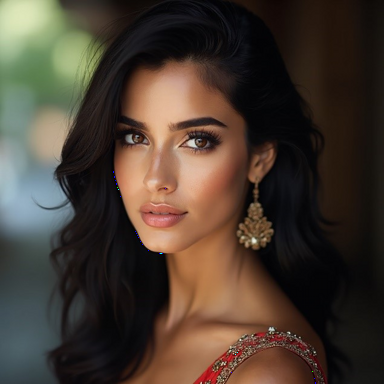
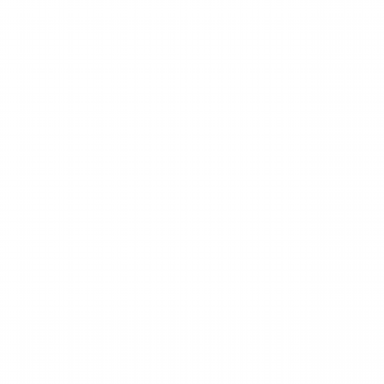

Seed: 10310400024853269999


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#@markdown <center><h1>Reflux</h1></center>

positive_prompt = "Portrait of a gorgeous Arabic supermodel of 22years with dark black hair, hazel eyes. Facing the camera. Shot in Sony A7III-200mm." # @param {"type":"string"}
width = 1024 # @param {"type":"slider","min":256,"max":2048,"step":1}
height = 1024 # @param {"type":"slider","min":256,"max":2048,"step":1}
fixed_seed = 0 # @param {"type":"number"}
guidance = 3.5 # @param {"type":"slider","min":0,"max":20,"step":0.5}
steps = 50 # @param {"type":"slider","min":4,"max":50,"step":1}
sampler_name = "ddim" # @param ["euler","heun","heunpp2","heunpp2","dpm_2","lms","dpmpp_2m","ipndm","deis","ddim","uni_pc","uni_pc_bh2"]
scheduler = "ddim_uniform" # @param ["normal","sgm_uniform","simple","ddim_uniform"]
batch_size = 1 # @param {"type":"slider","min":1,"max":20,"step":1}
auto_download = False # @param {"type":"boolean"}
if fixed_seed == 0:
        fixed_seed = random.randint(0, 18446744073709552000)
generate(positive_prompt, width, height, fixed_seed, guidance, steps, sampler_name, scheduler, batch_size, auto_download)